# Traffic Sign Recognition —— Model 
---

Course: **CSCI-GA 2271 Computer Vision**

Semester: **Fall 2022**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2022/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95% 

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard. 

# Dataset Preparation
___

1.  Download `dataset.zip` from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`. 
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it. 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/cv_kaggle_assignment/

Mounted at /content/drive
/content/drive/My Drive/cv_kaggle_assignment


# Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

batch_size = 64
momentum = 0.9
lr = 0.0005
epochs = 60
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

# Typical CNN structures (conv layers + flatten + fc layers) + Spatial Transformer Networks in the beginning
# Include batch normalization, ReLU non-linearity and max pooling after conv layers
# Spatial Transformer Networks, which explicitly allows the spatial manipulation of data within the network
# References: Spatial Transformer Networks (Jaderberg et al., 2016).
# https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=5),     # [n, 3, 32, 32] -> [n, 100, 28, 28]
            nn.BatchNorm2d(100),
            nn.ReLU(True),
            nn.Conv2d(100, 150, kernel_size=5),    # -> [n, 150, 24, 24]
            nn.BatchNorm2d(150),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2))             # -> [n, 150, 12, 12]
        self.conv2 = nn.Sequential(
            nn.Conv2d(150, 200, kernel_size=3),   # -> [n, 200, 10, 10] 
            nn.BatchNorm2d(200),
            nn.ReLU(True),
            nn.Conv2d(200, 300, kernel_size=3),   # -> [n, 300, 8, 8]
            nn.BatchNorm2d(300),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2))             # -> [n, 300, 4, 4]
        self.fc1 = nn.Sequential(
            nn.Linear(300 * 4 * 4, 300), 
            nn.BatchNorm1d(300),
            nn.ReLU(True),
            nn.Dropout())
        self.fc2 = nn.Linear(300, 43)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    # Spatial transformer network forward function
    def stn(self, x):
        # The localization network is a regular CNN which regresses the transformation parameters. 
        # The transformation is never learned explicitly from this dataset, instead the network learns automatically the 
        # spatial transformations that enhances the global accuracy.
        xs = self.localization(x)
        xs = xs.view(-1, 128 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        # The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
        grid = F.affine_grid(theta, x.size())

        # The sampler uses the parameters of the transformation and applies it to the input image.
        x = F.grid_sample(x, grid)

        return x    

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 300 * 4 * 4)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1) 


########################################################################################################
# The CNN and ResNet below are defined in my previous attempts, and are not used now. #
########################################################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),       # [N, 3, 32, 32] -> [N, 16, 28, 28]
            nn.BatchNorm2d(16),               # -> [N, 16, 14, 14]
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),       # [N, 32, 10, 10]
            nn.BatchNorm2d(32),               # -> [N, 32, 5, 5]
            nn.Dropout2d(),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 5 * 5, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout())
        self.fc2 = nn.Linear(256, nclasses)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x

class Block(nn.Module):
    def __init__(self, in_c, out_c, stride = 1):
        super(Block, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c)
        )

        if stride != 1 or in_c != out_c:
            self.residual = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.residual = nn.Sequential()

    def forward(self, x):
        residual = self.residual(x)
        x = self.layers(x)
        x += residual
        x = F.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_c = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.layer1 = self.make_layer(Block, 64, 2, stride=1)
        self.layer2 = self.make_layer(Block, 128, 2, stride=2)
        self.layer3 = self.make_layer(Block, 256, 2, stride=2)        
        self.layer4 = self.make_layer(Block, 512, 2, stride=2)
        self.fc = nn.Linear(512, 43)

    def make_layer(self, block, channel, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_c, channel, stride))
            self.in_c = channel
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        x = self.conv1(x)       # [N, 3, 32, 32] -> [N, 64, 34, ,34]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)       # -> [N, 64, 34, 34]
        x = self.layer2(x)       # -> [N, 128, 17, 17]
        x = self.layer3(x)       # -> [N, 256, 9, 9]
        x = self.layer4(x)       # -> [N, 512, 5, 5]
        x = F.avg_pool2d(x, 4)     # -> [N, 512, 1, 1]
        x = x.view(x.size(0), -1)    # -> [N, 512]
        x = self.fc(x)          # -> [N, 43]
        x = F.log_softmax(x,dim=1)
        return x

# Training

In [ ]:
# Ensemble method: create multiple models and then combine them to produce improved results
# I simply use a majority voting ensemble, which improves about 0.2% of final accuracy
num_models = 10

# model = Net()
# # model.load_state_dict(torch.load("./model_30.pth"))
# model = model.cuda()

models = [Net().cuda() for i in range(num_models)]

# optimizer = optim.Adam(model.parameters())
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

optimizers = [optim.Adam(models[i].parameters(), lr=lr) for i in range(num_models)]
schedulers = [optim.lr_scheduler.ExponentialLR(optimizers[i], gamma=0.9) for i in range(num_models)]
                             
def train(epoch):
    # model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # data += torch.from_numpy(np.random.uniform(-0.02, 0.02, (32, 32)))
        data = data.cuda()
        target = target.cuda()
        for i in range(num_models):
            optimizers[i].zero_grad()
            models[i].train()
            output = models[i](data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizers[i].step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        models[0].eval()
        output = models[0](data)
        for i in range(num_models):
            models[i].eval()
            output += models[i](data)
        output /= num_models
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(num_models):
        schedulers[i].step()

    return loss.item(), 100. * correct / len(train_loader.dataset)


def validation():
    # model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.cuda()
        target = target.cuda()
        models[0].eval()
        output = models[0](data)
        for i in range(num_models):
            models[i].eval()
            output += models[i](data)
        output /= num_models
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss, 100. * correct / len(val_loader.dataset)

training_loss = np.zeros(epochs)
validation_loss = np.zeros(epochs)
training_accuracy = np.zeros(epochs)
validation_accuracy = np.zeros(epochs)
for epoch in range(1, epochs + 1):
    training_loss[epoch - 1], training_accuracy[epoch - 1] = train(epoch)
    validation_loss[epoch - 1], validation_accuracy[epoch - 1] = validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(models[0].state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.970252
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.547853
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.116271
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.085825
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.072100
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.030216

Validation set: Average loss: 0.1736, Accuracy: 3767/3870 (97.34%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.024398
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.018411
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.063272
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.008649
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.088622
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.013629

Validation set: Average loss: 0.1504, Accuracy: 3763/3870 (97.24%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.030325
Train Epoch: 3 [6400/35339 (18%)]	Loss: 0.008082
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.009727
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.002959
Train Epoch: 3 [25600/

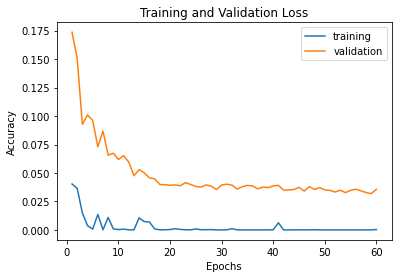

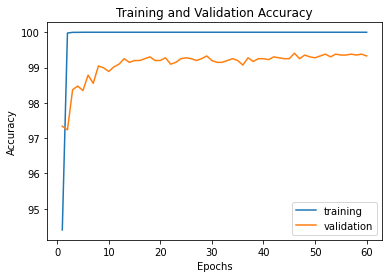

In [ ]:
plt.plot(np.arange(1, epochs + 1, 1), training_loss, label='training');
plt.plot(np.arange(1, epochs + 1, 1), validation_loss, label='validation');
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(np.arange(1, epochs + 1, 1), training_accuracy, label='training');
plt.plot(np.arange(1, epochs + 1, 1), validation_accuracy, label='validation');
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate and Submit to Kaggle



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
# model.eval() # Don't forget to put your model on eval mode !
for i in range(num_models):
    models[i].eval()

for i, data in enumerate(test_data):
    data = data.cuda()
    data = data.unsqueeze(0)

    # output = model(data)
    # pred = output.data.max(1, keepdim=True)[1].item()

    output = models[0](data)
    for j in range(num_models):
        output += models[j](data)
    output /= num_models
    pred = output.data.max(1, keepdim=True)[1].item() # get the index of the max log-probability

    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4278: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.